# Naive Bayes classifier

To classify the emotions, we can use the Naive Bayes classifier.

We will use the T(witter dataset)[] for this task.

## Get the Dataset

In [63]:
from datasets import load_dataset

# Specify the split to use
# SPLIT = "split"
SPLIT = "unsplit"

ds = load_dataset("dair-ai/emotion", SPLIT)

# Get the train, validation and test sets
train_set, val_set, test_set = None, None, None

if SPLIT == "split":
    train_set = ds["train"]
    test_set = ds["test"]
else:
    # Split the training, validation and test sets
    length = len(ds["train"])
    train_set = ds["train"].select(range(int(length * 0.8)))
    test_set = ds["train"].select(range(int(length * 0.8), length))

# Make sure the dataset is in the right format and in memory
train_set = train_set.map(lambda x: {"text": x["text"], "label": x["label"]})
test_set = test_set.map(lambda x: {"text": x["text"], "label": x["label"]})

Map: 100%|██████████| 83362/83362 [00:03<00:00, 24579.70 examples/s]


### List the different emotions in the dataset

In [12]:
__emotions = [
    "sadness",
    "joy",
    "love",
    "anger",
    "fear",
    "surprise",
]

EMOTION_TO_INDEX = {
    emotion: index for index, emotion in enumerate(__emotions)
}

INDEX_TO_EMOTION = {
    index: emotion for emotion, index in EMOTION_TO_INDEX.items()
}


### Pre-process the dataset

Before using the dataset, we need to pre-process it.

We will:
- Remove the stopwords
- Remove the punctuation
- Lemmatize the text
- Convert the text to lowercase

We will pre-process the training dataset, for it to be ready to train on.

In [64]:
import spacy

# load the English language model
nlp = spacy.load('en_core_web_sm')

"""
to pre-process the data, we will always apply the following:
- lowercasing
- removing extra whitespaces
"""
def pre_process_naive_bayes(text: str) -> list[str]:
    tokens = nlp(text)
    return [token.lemma_.lower().strip() for token in tokens if not token.is_stop]

def pre_process_naive_bayes_batch(texts: list[str]) -> list[list[str]]:
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=1024):  # Adjust batch_size based on memory
        processed_texts.append([token.lemma_.lower().strip() for token in doc])
        if len(processed_texts) % 1000 == 0:
            print("Processed", len(processed_texts), "texts")
    return processed_texts

pre_processed_train_set = [
    {"tokens": tokens, "label": train_set[i]["label"]}
    for i, tokens in enumerate(pre_process_naive_bayes_batch([example["text"] for example in train_set]))
]


Processed 1000 texts
Processed 2000 texts
Processed 3000 texts
Processed 4000 texts
Processed 5000 texts
Processed 6000 texts
Processed 7000 texts
Processed 8000 texts
Processed 9000 texts
Processed 10000 texts
Processed 11000 texts
Processed 12000 texts
Processed 13000 texts
Processed 14000 texts
Processed 15000 texts
Processed 16000 texts
Processed 17000 texts
Processed 18000 texts
Processed 19000 texts
Processed 20000 texts
Processed 21000 texts
Processed 22000 texts
Processed 23000 texts
Processed 24000 texts
Processed 25000 texts
Processed 26000 texts
Processed 27000 texts
Processed 28000 texts
Processed 29000 texts
Processed 30000 texts
Processed 31000 texts
Processed 32000 texts
Processed 33000 texts
Processed 34000 texts
Processed 35000 texts
Processed 36000 texts
Processed 37000 texts
Processed 38000 texts
Processed 39000 texts
Processed 40000 texts
Processed 41000 texts
Processed 42000 texts
Processed 43000 texts
Processed 44000 texts
Processed 45000 texts
Processed 46000 tex

In [65]:

from collections import Counter
import numpy as np
from typing import Callable
from collections import defaultdict

"""
Multi-class, Uni-Label N-gram Naive Bayes Classifier
"""
class MCULNgramNaiveBayesClassifier:
    """
    n: int The n-gram size
    labels: list[str] The list of labels
    pre_processor: Callable[[str], list[str]] The pre-processing function
    laplace_constant: int The Laplace smoothing constant
    alpha: float The alpha parameter for the reweighting of prior probabilities
    """
    def __init__(self, *, n, labels: list[str], pre_processor: Callable[[str], list[str]], laplace_constant=1, alpha=1):
        self.n = n
        self.labels = labels
        self.label_to_index = {label: index for index, label in enumerate(labels)}
        self.index_to_label = {index: label for index, label in enumerate(labels)}
        self.label_count_for_ngrams = Counter()
        self.label_percentage_for_ngrams = Counter()
        self.pre_processor = pre_processor
        self.prior = None

        # hyper parameters
        self.laplace_constant = laplace_constant
        self.log_laplace_constant = np.log(laplace_constant)
        self.alpha = alpha

    """
    Generate n-grams from a sentence
    """
    def ngrams(self, sentence: list[str]):
        for i in range(len(sentence) - self.n + 1):
            yield tuple(sentence[i:i + self.n])

    """
    Count the number of times each n-gram appears in each label
    """
    def get_label_counts_for_ngrams(self, pre_processed_dataset: list[dict[str: list[str] | int]]) -> Counter:
        label_count_for_ngrams = {}
        for example in pre_processed_dataset:
            for ngram in self.ngrams(example["tokens"]):
                if ngram not in label_count_for_ngrams:
                    label_count_for_ngrams[ngram] = {emotion: 0 for emotion in self.labels}
                emotion_index = example["label"]
                emotion = self.index_to_label[emotion_index]
                label_count_for_ngrams[ngram][emotion] += 1
        return label_count_for_ngrams

    """
    Convert counts to probabilities
    """
    def counts_to_probabilities(self, label_count_for_ngrams: Counter) -> Counter:
        label_prob_for_ngrams = Counter()
        for ngram, label_counts in label_count_for_ngrams.items():
            total = sum(label_counts.values())
            label_prob_for_ngrams[ngram] = {label: count / total for label, count in label_counts.items()}
        return label_prob_for_ngrams

    """
    Calculate the probability of an n-gram appearing in a label, from the counts of n-grams in each label
    """
    def proba_for_ngram_in_label(self, ngram, label: str):
        # Handle missing ngrams with Laplace smoothing
        if ngram not in self.label_count_for_ngrams:
            return self.laplace_constant / len(self.labels)

        # For seen ngrams, apply Laplace smoothing
        total_count = sum(self.label_count_for_ngrams[ngram].values())
        smoothed_count = self.label_count_for_ngrams[ngram][label] + self.laplace_constant
        return smoothed_count / (total_count + len(self.labels))

    """
    Calculate the probability of a sentence appearing in a label, by multiplying the probabilities of each n-gram
    """
    def prob_for_sentence_in_label_ngram(self, sentence: list[str], label: str):
        log_prob = 0
        for ngram in self.ngrams(sentence):
            prob = self.proba_for_ngram_in_label(ngram, label)
            if prob > 0:
                log_prob += np.log(prob)
            else:
                log_prob += (self.log_laplace_constant - np.log(len(self.labels)))
        return np.exp(log_prob)

    def get_emotion_counts(self, dataset):
        emotion_counts = {}
        for example in dataset:
            for emotion_index in [example["label"]]:
                emotion = self.index_to_label[emotion_index]
                if emotion not in emotion_counts:
                    emotion_counts[emotion] = 0
                emotion_counts[emotion] += 1
        # sort the emotions in the same order as the labels list
        emotion_counts = {emotion: emotion_counts[emotion] for emotion in self.labels}
        return emotion_counts

    """
    Calculate the prior probabilities of each label
    """
    def get_prior(self, pre_processed_dataset: list[dict[str: str | list[int]]]):
        label_counts = self.get_emotion_counts(pre_processed_dataset)
        total_examples = sum(label_counts[example] for example in label_counts)
        emotion_class_counts = {emotion: label_counts[emotion] for emotion in self.labels}
        return {emotion: count / total_examples for emotion, count in emotion_class_counts.items()}

    def proba_for_sentence_for_each_emo_ngram(self, sentence: list[str]):
        probas = {label: self.prob_for_sentence_in_label_ngram(sentence, label) for label in self.labels}
        # Reweight by prior probabilities
        probas = {label: (prob ** (1 - self.alpha)) * (self.prior[label] ** self.alpha) for label, prob in probas.items()}
        # Normalize to sum to 1
        total_proba = sum(probas.values())
        if total_proba > 0:
            probas = {label: prob / total_proba for label, prob in probas.items()}
        return probas

    def predict_label(self, sentence: str):
        pre_processed_sentence = self.pre_processor(sentence)
        probas = self.proba_for_sentence_for_each_emo_ngram(pre_processed_sentence)
        return sorted(probas.items(), key=lambda x: x[1], reverse=True)[:3]

    def train(self, pre_processed_dataset: list[dict[str: list[str] | int]]):
        self.label_count_for_ngrams = self.get_label_counts_for_ngrams(pre_processed_dataset)
        self.label_percentage_for_ngrams = self.counts_to_probabilities(self.label_count_for_ngrams)
        self.prior = self.get_prior(pre_processed_dataset)

# Instantiate the model and train it
model = MCULNgramNaiveBayesClassifier(
    n=2,
    labels=__emotions,
    pre_processor=pre_process_naive_bayes,
    laplace_constant=0.8,
    alpha=0.01875
)
model.train(pre_processed_train_set)

In [66]:
import matplotlib.pyplot as plt

%matplotlib inline

def evaluate(model: Callable[[str], str], test_set: list[dict[str: str | list[int]]]):
    correct_predictions = defaultdict(int)
    total_predictions = defaultdict(int)

    # Iterate over the test set
    for example in test_set:
        sentence = example["text"]
        true_label_index = example["label"]
        true_label = INDEX_TO_EMOTION[true_label_index]

        # Get predictions
        predicted_emotion = model(sentence)

        # Update counts for each true label
        total_predictions[true_label] += 1
        if predicted_emotion == true_label:
            correct_predictions[true_label] += 1

    # Calculate accuracy for each emotion
    label_accuracy = {
        label: (correct_predictions[label] / total_predictions[label] * 100)
            if total_predictions[label] > 0 else 0
            for label in __emotions
    }
    total_accuracy = sum(correct_predictions.values()) / sum(total_predictions.values()) * 100
    return total_accuracy, label_accuracy

def plot_eval(model: Callable[[str], str], test_set: list[dict[str: str | list[int]]], title: str):
    total_accuracy, emotion_accuracy = evaluate(model, test_set)

    # Plotting a single bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(emotion_accuracy.keys(), emotion_accuracy.values(), color='skyblue')
    plt.title("Accuracy per emotion - " + title, fontsize=16)
    plt.xlabel("Emotion", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    # Print the accuracy values
    print("Accuracy per emotion:")
    for emotion, accuracy in emotion_accuracy.items():
        print(f"{emotion}: {accuracy:.2f}%")

    print(f"Total accuracy: {total_accuracy:.2f}%")

# 3 different models

def model_random(sentence: str) -> str:
    return np.random.choice(__emotions)

def model_majority(sentence: str) -> str:
    return "joy"

def model_naive_bayes(sentence: str) -> str:
    return model.predict_label(sentence)[0][0]


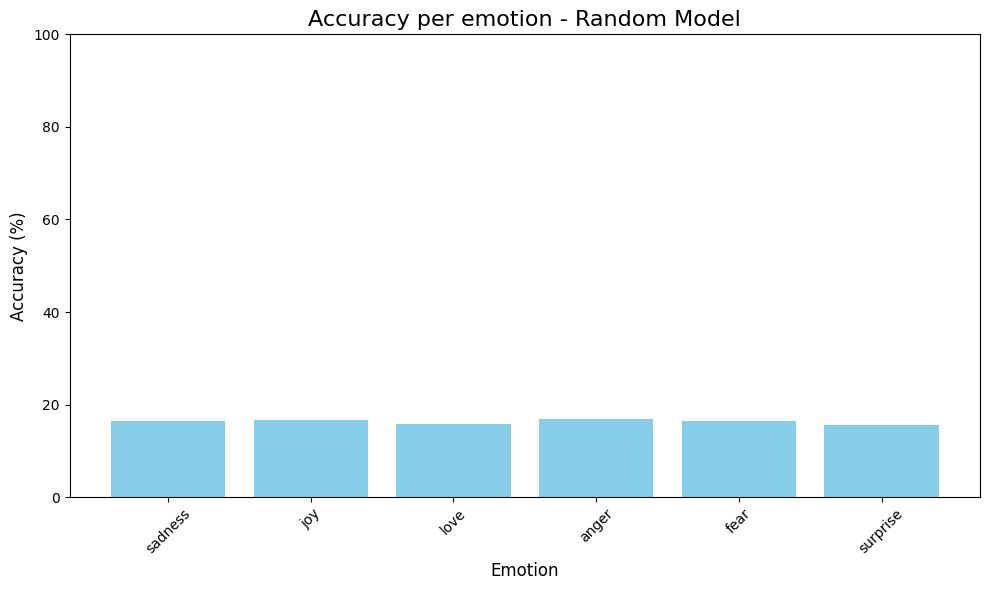

Accuracy per emotion:
sadness: 16.44%
joy: 16.68%
love: 15.89%
anger: 16.81%
fear: 16.52%
surprise: 15.67%
Total accuracy: 16.51%


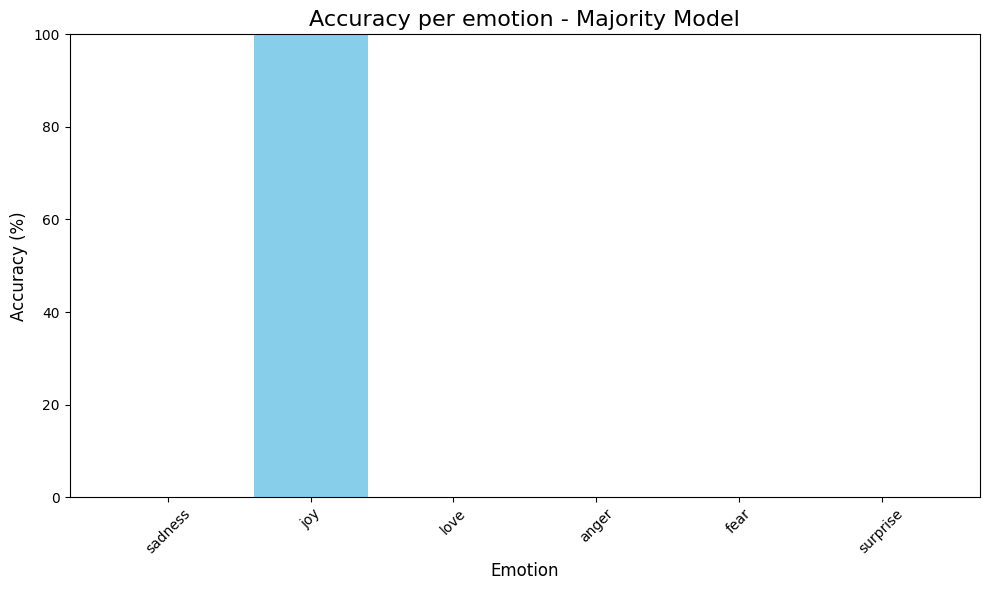

Accuracy per emotion:
sadness: 0.00%
joy: 100.00%
love: 0.00%
anger: 0.00%
fear: 0.00%
surprise: 0.00%
Total accuracy: 33.87%


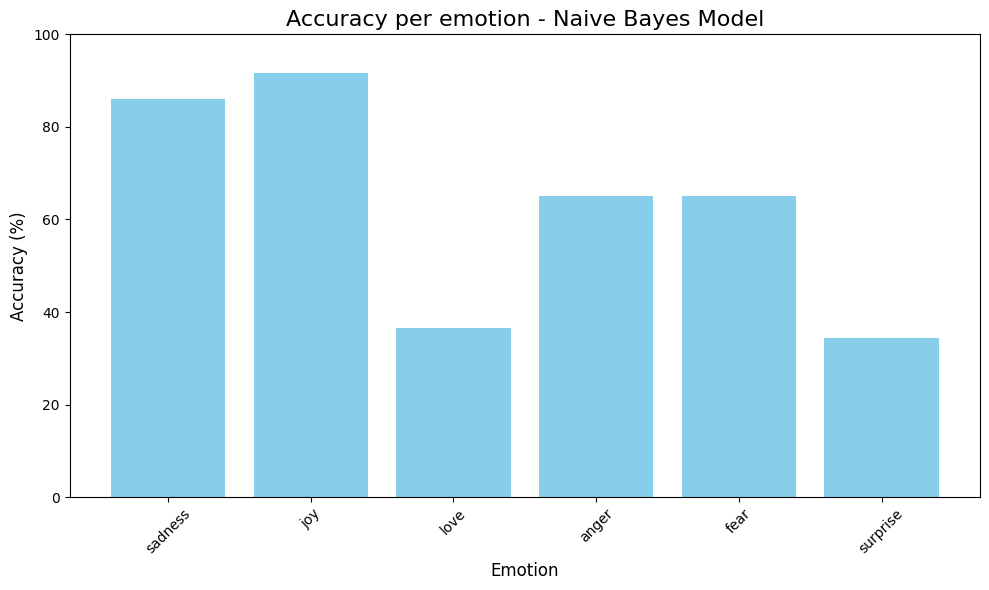

Accuracy per emotion:
sadness: 85.95%
joy: 91.59%
love: 36.64%
anger: 65.09%
fear: 65.10%
surprise: 34.30%
Total accuracy: 76.63%


In [67]:
plot_eval(model_random, test_set, "Random Model")
plot_eval(model_majority, test_set, "Majority Model")
plot_eval(model_naive_bayes, test_set, "Naive Bayes Model")

In [ ]:
from multiprocessing import Pool

def train_with(laplace, alpha, n):
    model = MCULNgramNaiveBayesClassifier(
        n=n,
        labels=__emotions,
        pre_processor=pre_process_naive_bayes,
        laplace_constant=laplace,
        alpha=alpha
    )
    def model_naive_bayes(sentence: str) -> str:
        return model.predict_label(sentence)[0][0]

    model.train(pre_processed_train_set)
    r = evaluate(model_naive_bayes, test_set)
    print(f"Alpha={alpha}, Laplace={laplace}, N={n}, Accuracy={r[0]}")
    return r

def grid_search():
    best_accuracy = 0
    best_params = None

    # first step
    # laplaces = [0.1, 0.5, 1, 2, 5]
    # alphas = [0, 0.1, 0.3, 0.5, 0.7, 1]
    # ns = [1, 2, 3, 4]

    # second step
    # the best laplace is somewhere between 0.1 and 1
    # the best alpha is somewhere between 0 and 0.3
    # the best n is 2
    # laplaces = np.linspace(0.1, 1, 5)
    # alphas = np.linspace(0, 0.3, 5)
    # ns = [2]

    # third step
    # the best laplace is somewhere between 0.2 and 0.01
    # the best alpha is somewhere between 0 and 0.15
    # laplaces = np.linspace(0.55, 1, 5)
    # alphas = np.linspace(0, 0.15, 5)
    # ns = [2]

    # fourth step
    # the best laplace is somewhere between 0.9 and 0.7
    # the best alpha is somewhere between 0 and 0.075
    laplaces = np.linspace(0.7, 0.9, 5)
    alphas = np.linspace(0, 0.075, 5)
    ns = [2]

    # Best parameters: Laplace=0.8, Alpha=0.01875, N=2
    params = [(laplace, alpha, n) for laplace in laplaces for alpha in alphas for n in ns]

    history = []
    # use multi threading to speed up the process
    with Pool() as p:
        results = p.starmap(train_with, [(laplace, alpha, n) for laplace, alpha, n in params])
        for i, (total_accuracy, _) in enumerate(results):
            if total_accuracy > best_accuracy:
                best_accuracy = total_accuracy
                best_params = (params[i][0], params[i][1], params[i][2])
            history.append((params[i][0], params[i][1], params[i][2], total_accuracy))

    print("Best parameters: Laplace={}, Alpha={}, N={}".format(best_params[0], best_params[1], best_params[2]))
    print("Best accuracy:", best_accuracy)
    return history

history = grid_search()

Alpha=0.0375, Laplace=0.7, N=2, Accuracy=70.65
Alpha=0.0, Laplace=0.7, N=2, Accuracy=69.5
Alpha=0.01875, Laplace=0.75, N=2, Accuracy=70.7
Alpha=0.0375, Laplace=0.75, N=2, Accuracy=70.65
Alpha=0.075, Laplace=0.7, N=2, Accuracy=70.55
Alpha=0.01875, Laplace=0.7, N=2, Accuracy=70.7
Alpha=0.056249999999999994, Laplace=0.7, N=2, Accuracy=70.65
Alpha=0.0, Laplace=0.75, N=2, Accuracy=69.5
Alpha=0.075, Laplace=0.75, N=2, Accuracy=70.55
Alpha=0.056249999999999994, Laplace=0.75, N=2, Accuracy=70.7
Alpha=0.0375, Laplace=0.8, N=2, Accuracy=70.7
Alpha=0.0, Laplace=0.8, N=2, Accuracy=69.5
Alpha=0.01875, Laplace=0.8, N=2, Accuracy=70.8
Alpha=0.056249999999999994, Laplace=0.8, N=2, Accuracy=70.6
Alpha=0.0, Laplace=0.85, N=2, Accuracy=69.45
Alpha=0.075, Laplace=0.8, N=2, Accuracy=70.45
Alpha=0.056249999999999994, Laplace=0.85, N=2, Accuracy=70.45
Alpha=0.01875, Laplace=0.85, N=2, Accuracy=70.75
Alpha=0.0375, Laplace=0.85, N=2, Accuracy=70.6
Alpha=0.01875, Laplace=0.9, N=2, Accuracy=70.6
Alpha=0.0, Lapla

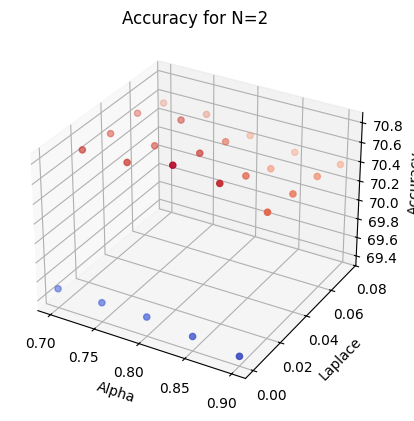

In [56]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_3d_for_n(history, n, ax):
    alphas = [x[0] for x in history if x[2] == n]
    laplaces = [x[1] for x in history if x[2] == n]
    accuracies = [x[3] for x in history if x[2] == n]

    ax.scatter(alphas, laplaces, accuracies, c=accuracies, cmap=cm.coolwarm)
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Laplace')
    ax.set_zlabel('Accuracy')
    ax.set_title(f"Accuracy for N={n}")

def plot_3d(history, n):
    fig = plt.figure(n)
    ax = fig.add_subplot(111, projection='3d')

    alphas = [x[0] for x in history if x[2] == n]
    laplaces = [x[1] for x in history if x[2] == n]
    accuracies = [x[3] for x in history if x[2] == n]

    ax.scatter(alphas, laplaces, accuracies, c=accuracies, cmap=cm.coolwarm)
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Laplace')
    ax.set_zlabel('Accuracy')
    ax.set_title(f"Accuracy for N={n}")

# plot_3d(history, 1)
plot_3d(history, 2)
# plot_3d(history, 3)
# plot_3d(history, 4)

plt.show()